Libraries

In [2]:
from pystac_client import Client # type:ignore
import planetary_computer as pc # type:ignore
from shapely.geometry import Polygon # type:ignore
import requests # type:ignore
import numpy as np # type:ignore
import rasterio # type:ignore
from io import BytesIO # type:ignore
from scipy.ndimage import zoom
import os
import matplotlib.pyplot as plt

Coordonnées + date d'intérêt

In [3]:
# zone géographique
xmin = 1.35 
ymin = 43.55 
xmax = 1.48 
ymax = 43.63
bbox_toulouse = [xmin, ymin, xmax, ymax]  # Coord du centre de la zone géographique, ici on a choisi toulouse mais à changer si on veut Massy par ex.

# période d'intérêt ( environ période de 3 mois )
datetime= "2020-06-01/2020-08-31" # à changer si on veut une autre période/ autre année/ ...

# construction du polygone sur la zone que l'on souhaite
geometry = Polygon([
    (bbox_toulouse[0], bbox_toulouse[1]), # coin en bas à gauche
    (bbox_toulouse[0], bbox_toulouse[3]), # coin en haut à gauche
    (bbox_toulouse[2], bbox_toulouse[3]), # coin en haut à droite
    (bbox_toulouse[2], bbox_toulouse[1]), # coin en bas droite
    (bbox_toulouse[0], bbox_toulouse[1])  # retour au coin en  bas à gauche pour fermer
    ])

In [4]:
# Connexion au STAC API de Planetary Computer
stac_api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
client = Client.open(stac_api_url)

search = client.search(
    bbox = bbox_toulouse, 
    datetime = datetime, 
    collections = ["sentinel-2-l2a"],
    query = {"eo:cloud_cover": {"lte": 5}} # on prend les images avec couverture nuageuse en dessous de 5%
)

In [5]:
# on récupère tte les images qui correspondent à notre search
items = list(search.items())
print(f"Il y'a {len(items)} images qui correspondent à nos critères définis ( date, localisation, couverture nuageuse) sur la période {datetime}.")

items_sorted = sorted(items, key=lambda item: item.properties['eo:cloud_cover']) # on trie dans l'ordre croissant selon la couverture nuageuse de l'image
selected_items = items_sorted[:1] # on sélectionne la première image, donc l'image qui a la couverture nuageuse la plus faible

for i, item in enumerate(selected_items):
    print(f"\n{i+1}. \n ID : {item.id}, \n Date : {item.datetime}, \n Couverture nuageuse: {item.properties['eo:cloud_cover']} %") 

Il y'a 5 images qui correspondent à nos critères définis ( date, localisation, couverture nuageuse) sur la période 2020-06-01/2020-08-31.

1. 
 ID : S2A_MSIL2A_20200808T105031_R051_T31TCJ_20200815T105847, 
 Date : 2020-08-08 10:50:31.024000+00:00, 
 Couverture nuageuse: 0.048175 %


In [7]:
# Téléchargement de l'asset "visual"
for i, item in enumerate(selected_items):
    print(f"{i+1}. ID : {item.id}, Date : {item.datetime}, Cloud Cover : {item.properties['eo:cloud_cover']}") 
   
    visual_asset = item.assets.get("visual")
    
    if visual_asset:
        signed_visual_url = pc.sign(visual_asset.href)
        visual_response = requests.get(signed_visual_url)
        
        with rasterio.open(BytesIO(visual_response.content)) as visual_raster:
            visual_data = visual_raster.read([1, 2, 3])  # R, G, B
            print(f"  Image visuelle téléchargée. Shape : {visual_data.shape}")
            visual_profile = visual_raster.profile

            visual_filename = "Asset_visual_RGB.tif"
            with rasterio.open(visual_filename, 'w', **visual_profile) as visual_dataset:
                visual_dataset.write(visual_data)
            # print(f"Image visuelle sauvegardée : {visual_filename}")
            
            # Plot de l'image visuelle
            plt.figure(figsize=(5, 5))
            plt.imshow(np.moveaxis(visual_data, 0, -1))  # Reorder dimensions for plotting
            plt.title("Image")
            plt.axis('off')
            plt.show()

1. ID : S2A_MSIL2A_20200808T105031_R051_T31TCJ_20200815T105847, Date : 2020-08-08 10:50:31.024000+00:00, Cloud Cover : 0.048175


KeyboardInterrupt: 

In [8]:
def download_band(band_key, band_asset, profile_container):
    """Télécharge une bande Sentinel-2 et retourne ses données"""
    signed_url = pc.sign(band_asset.href)
    response = requests.get(signed_url)
    
    with rasterio.open(BytesIO(response.content)) as raster:
        band_data = raster.read(1)
        profile_container[band_key] = raster.profile
        print(f"Bande {band_key} téléchargée. Shape : {band_data.shape}")
        
    return band_data

In [9]:
def min_max_normalization(band):
    band_min = band.min()
    band_max = band.max()
    return (band - band_min) / (band_max - band_min + 1e-10)  # Ajout de 1e-10 pour éviter la division par zéro

In [10]:
for i, item in enumerate(selected_items):
    print(f"ID : {item.id}, Date : {item.datetime}")
    
    blue_data = None  
    green_data = None
    red_data = None
    nir_data = None
    swir_data = None

    profile_container = {}
    
    for band_key, band_asset in item.assets.items():
        if band_key in ["B04", "B08", "B03", "B11", "B02"]: 
            if band_key == "B04":
                red_data = download_band(band_key, band_asset, profile_container)  
                print(red_data.min())
                print(red_data.max())
            elif band_key == "B08":
                nir_data = download_band(band_key, band_asset, profile_container) 
                print(nir_data.min())
                print(nir_data.max())
            elif band_key == "B03":
                green_data = download_band(band_key, band_asset, profile_container) 
                print(green_data.min())
                print(green_data.max())
            elif band_key == "B11":
                swir_data = download_band(band_key, band_asset, profile_container)  
                print(swir_data.min())
                print(swir_data.max())
            elif band_key == "B02":
                blue_data = download_band(band_key, band_asset, profile_container) 
                print(blue_data.min())
                print(blue_data.max())

    if red_data is not None and nir_data is not None and green_data is not None and swir_data is not None and blue_data is not None:
        
        # on rééchantillonnage les bandes si besoin
        if red_data.shape != nir_data.shape:
            print("Rééchantillonnage de la bande NIR pour correspondre à la bande rouge.")
            nir_data = zoom(nir_data, (red_data.shape[0] / nir_data.shape[0], red_data.shape[1] / nir_data.shape[1]), order=3)

        if swir_data.shape != red_data.shape:
            print("Rééchantillonnage de la bande SWIR pour correspondre à la bande rouge.")
            swir_data = zoom(swir_data, (red_data.shape[0] / swir_data.shape[0], red_data.shape[1] / swir_data.shape[1]), order=3)

        if blue_data.shape != red_data.shape:
            print("Rééchantillonnage de la bande bleue pour correspondre à la bande rouge.")
            blue_data = zoom(blue_data, (red_data.shape[0] / blue_data.shape[0], red_data.shape[1] / blue_data.shape[1]), order=3)

        # Normalisation des données après rééchantillonnage
    
        nir_data_normalized = min_max_normalization(nir_data)
        red_data_normalized = min_max_normalization(red_data)
        green_data_normalized = min_max_normalization(green_data)
        blue_data_normalized = min_max_normalization(blue_data)
        swir_data_normalized = min_max_normalization(swir_data)

        try:
            try:
                ndvi = (nir_data_normalized - red_data_normalized) / (nir_data_normalized + red_data_normalized)  
            except ZeroDivisionError:
                print("  Division par zéro détectée dans le calcul du NDVI, valeur NaN attribuée.")
                ndvi = np.nan_to_num((nir_data_normalized - red_data_normalized) / (nir_data_normalized + red_data_normalized), nan=-9999)
            
            print(f"  NDVI min: {ndvi.min()}, NDVI max: {ndvi.max()}")
            
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"NDVI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(ndvi.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=ndvi.min(), MAX_INDEX=ndvi.max(), DESCRIPTION=f"NDVI entre {ndvi.min()} et {ndvi.max()}")
            print(f"  NDVI calculé et sauvegardé : {filename}")
            
            
        except Exception as e:
            print(f"  Erreur lors du calcul de NDVI: {e}")
        
        try:
            # Calcul de NDMI avec NIR et SWIR
            try:
                ndmi = (nir_data_normalized - swir_data_normalized) / (nir_data_normalized + swir_data_normalized)  # Formule NDMI
            except ZeroDivisionError:
                print("  Division par zéro détectée dans le calcul du NDMI, valeur NaN attribuée.")
                ndmi = np.nan_to_num((nir_data_normalized - swir_data_normalized) / (nir_data_normalized + swir_data_normalized), nan=-9999)
            
            print(f"  NDMI min: {ndmi.min()}, NDMI max: {ndmi.max()}")
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"NDMI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(ndmi.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=ndmi.min(), MAX_INDEX=ndmi.max(), DESCRIPTION=f"NDMI entre {ndmi.min()} et {ndmi.max()}")
            print(f"  NDMI calculé et sauvegardé : {filename}")
        except Exception as e:
            print(f"  Erreur lors du calcul de NDMI: {e}")
        
        try:
            # Calcul de NDBI avec SWIR et NIR
            try:
                ndbi=(swir_data_normalized - nir_data_normalized) / (swir_data_normalized + nir_data_normalized)            
            except ZeroDivisionError:
                print("  Division par zéro détectée dans le calcul du NDBI, valeur NaN attribuée.")
                ndbi = np.nan_to_num((swir_data_normalized - nir_data_normalized) / (swir_data_normalized + nir_data_normalized) , nan=-9999)
            print(f"  NDBI min: {ndbi.min()}, NDBI max: {ndbi.max()}")
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"NDBI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(ndbi.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=ndbi.min(), MAX_INDEX=ndbi.max(), DESCRIPTION=f"NDBI entre {ndbi.min()} et {ndbi.max()}")
            print(f"  NDBI calculé et sauvegardé : {filename}")
        except Exception as e:
            print(f"  Erreur lors du calcul de NDBI: {e}")
        
        try:
            # Calcul de NDWI avec vert et NIR
            ndwi = (green_data_normalized - nir_data_normalized) / (green_data_normalized + nir_data_normalized)
            print(f"  NDWI min: {ndwi.min()}, NDWI max: {ndwi.max()}")
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"NDWI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(ndwi.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=ndwi.min(), MAX_INDEX=ndwi.max(), DESCRIPTION=f"NDWI entre {ndwi.min()} et {ndwi.max()}")
            print(f"  NDWI calculé et sauvegardé : {filename}")
        except Exception as e:
            print(f"  Erreur lors du calcul de NDWI: {e}")
        
        try:
            # Calcul de UI avec SWIR et NIR
            ui = swir_data_normalized / nir_data_normalized
            print(f"  UI min: {ui.min()}, UI max: {ui.max()}")
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"UI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(ui.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=ui.min(), MAX_INDEX=ui.max(), DESCRIPTION=f"UI entre {ui.min()} et {ui.max()}")
            print(f"  UI calculé et sauvegardé : {filename}")
        except Exception as e:
            print(f"  Erreur lors du calcul de UI: {e}")
        
        try:
            # Calcul de BSI avec SWIR, NIR, bleu et rouge
            bsi = ((swir_data_normalized + red_data_normalized) - (nir_data_normalized + blue_data_normalized)) / (swir_data_normalized + red_data_normalized + nir_data_normalized + blue_data_normalized)
            print(f"  BSI min: {bsi.min()}, BSI max: {bsi.max()}")
            profile = profile_container["B04"].copy()
            profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-9999)
            filename = f"BSI_bon.tif"
            with rasterio.open(filename, 'w', **profile) as dataset:
                dataset.write(bsi.astype(rasterio.float32), 1)
                dataset.update_tags(MIN_INDEX=bsi.min(), MAX_INDEX=bsi.max(), DESCRIPTION=f"BSI entre {bsi.min()} et {bsi.max()}")
            print(f"  BSI calculé et sauvegardé : {filename}")
        except Exception as e:
            print(f"  Erreur lors du calcul de BSI: {e}")

    else:
        print(f"  Impossible de calculer les indices pour {item.id}, bandes manquantes.")

ID : S2A_MSIL2A_20200808T105031_R051_T31TCJ_20200815T105847, Date : 2020-08-08 10:50:31.024000+00:00


KeyboardInterrupt: 

NameError: name 'ndvi' is not defined

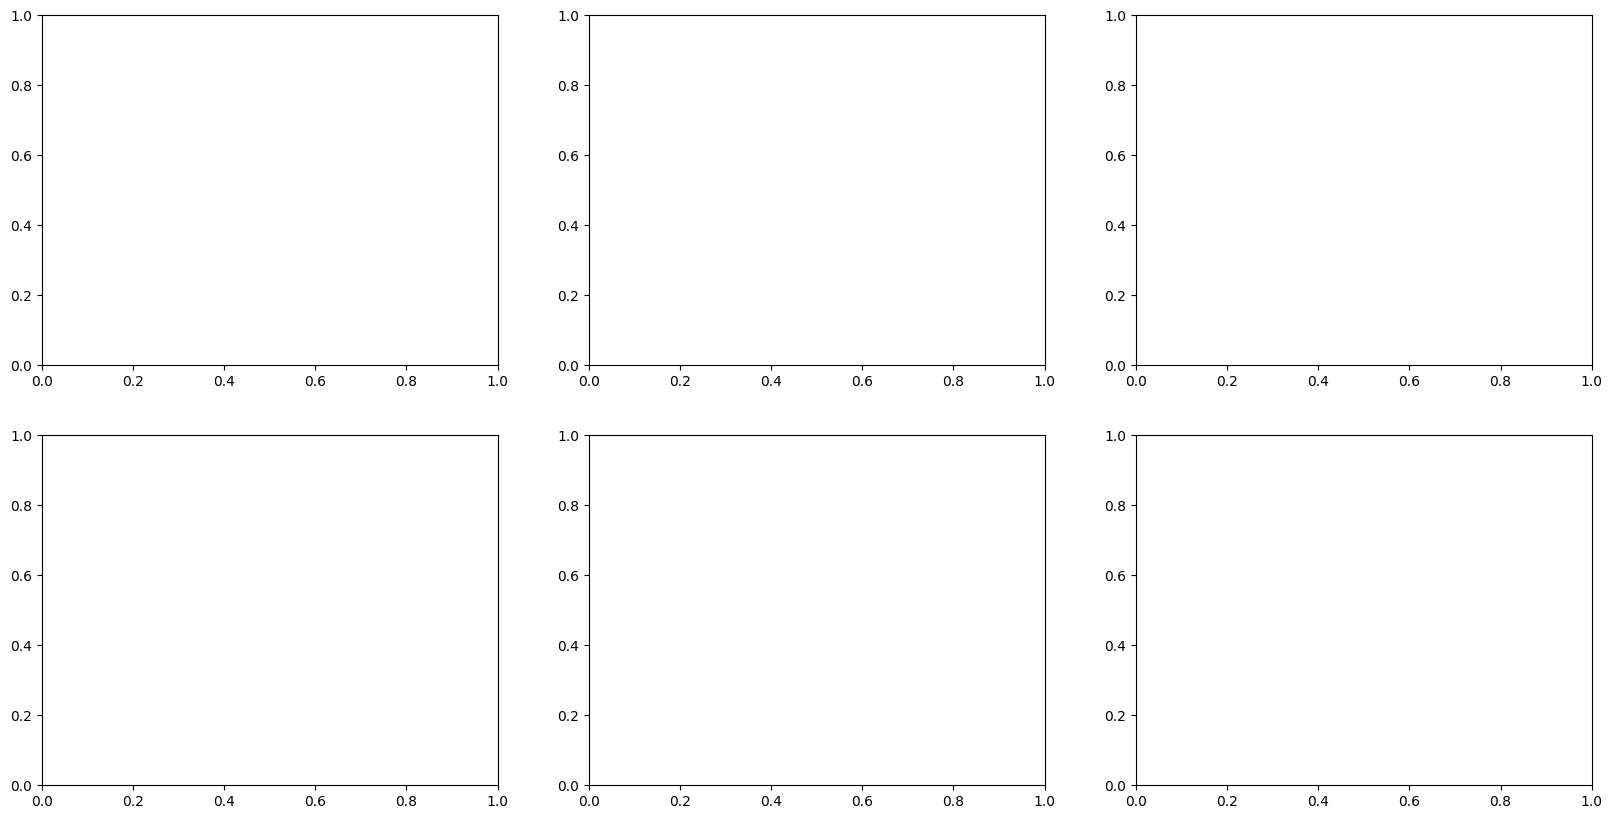

In [11]:
downsample_factor = 10

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# NDVI
ndvi_downsampled = ndvi[::downsample_factor, ::downsample_factor]
axes[0, 0].imshow(ndvi_downsampled, cmap='Greens')
axes[0, 0].set_title('Image NDVI')
axes[0, 0].axis('off')
fig.colorbar(axes[0, 0].imshow(ndvi_downsampled, cmap='Greens'), ax=axes[0, 0], label='NDVI')

# NDWI
ndwi_downsampled = ndwi[::downsample_factor, ::downsample_factor]
axes[0, 1].imshow(ndwi_downsampled, cmap='Blues')
axes[0, 1].set_title('Image NDWI')
axes[0, 1].axis('off')
fig.colorbar(axes[0, 1].imshow(ndwi_downsampled, cmap='Blues'), ax=axes[0, 1], label='NDWI')

# NDMI


ndmi_downsampled = ndmi[::downsample_factor, ::downsample_factor]
axes[0, 2].imshow(ndmi_downsampled, cmap='Accent_r')
axes[0, 2].set_title('Image NDMI')
axes[0, 2].axis('off')
fig.colorbar(axes[0, 2].imshow(ndmi_downsampled, cmap='Accent_r'), ax=axes[0, 2], label='NDMI')

# NDBI
ndbi_downsampled = ndbi[::downsample_factor, ::downsample_factor]
axes[1, 0].imshow(ndbi_downsampled, cmap='OrRd')
axes[1, 0].set_title('Image NDBI')
axes[1, 0].axis('off')
fig.colorbar(axes[1, 0].imshow(ndbi_downsampled, cmap='OrRd'), ax=axes[1, 0], label='NDBI')

# UI
ui_downsampled = ui[::downsample_factor, ::downsample_factor]
axes[1, 1].imshow(ui_downsampled, cmap='Purples')
axes[1, 1].set_title('Image UI')
axes[1, 1].axis('off')
fig.colorbar(axes[1, 1].imshow(ui_downsampled, cmap='Purples'), ax=axes[1, 1], label='UI')

# BSI
bsi_downsampled = bsi[::downsample_factor, ::downsample_factor]
axes[1, 2].imshow(bsi_downsampled, cmap='coolwarm')
axes[1, 2].set_title('Image BSI')
axes[1, 2].axis('off')
fig.colorbar(axes[1, 2].imshow(bsi_downsampled, cmap='coolwarm'), ax=axes[1, 2], label='BSI')

plt.tight_layout()
plt.show()

In [ ]:
import rasterio
from rasterio.plot import show

def classify_urban(ndvi, ndwi, bare_soil, b11):
    rows, cols = ndvi.shape
    classified_image = np.zeros((rows, cols, 3), dtype=np.float32)

    for i in range(rows):
        for j in range(cols):
            if ndwi[i, j] > 0.2:
                # Eau 
                classified_image[i, j] = [0, 0.5, 1]
            elif b11[i, j] > 0.8 or ndvi[i, j] < 0.1:
                # Zones bâties 
                classified_image[i, j] = [1, 1, 1]
            elif ndvi[i, j] > 0.2:
                # Végétation 
                classified_image[i, j] = [0, 0.3 * ndvi[i, j], 0]
            else:
                # Sol nu
                classified_image[i, j] = [bare_soil[i, j], 0.2, 0]

    return classified_image
bare_soil = 2.5 * ((swir_data_normalized+red_data_normalized)-(nir_data_normalized+blue_data_normalized))/((swir_data_normalized+red_data_normalized)+(nir_data_normalized+blue_data_normalized))

if ndvi is not None and ndwi is not None and bare_soil is not None and swir_data_normalized is not None:
    classified_image = classify_urban(ndvi, ndwi, bare_soil, swir_data_normalized)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(classified_image)
    plt.title("Image Classifiée (Urbaine)")
    plt.axis("off")
    plt.show()

    profile = profile_container["B04"].copy()
    profile.update(dtype=rasterio.float32, count=3, compress='lzw')
    filename = "Urban_Classification.tif"
    with rasterio.open(filename, 'w', **profile) as dataset:
        for band in range(3):
            dataset.write(classified_image[:, :, band], band + 1)
    print(f"Image classifiée sauvegardée : {filename}")

C:\Users\urbin\AppData\Local\Temp\ipykernel_7792\2803074620.py:24: RuntimeWarning: invalid value encountered in divide
  bare_soil = 2.5 * ((swir_data_normalized+red_data_normalized)-(nir_data_normalized+blue_data_normalized))/((swir_data_normalized+red_data_normalized)+(nir_data_normalized+blue_data_normalized))
